# Project : Airbnb New User Booking
---

### Abstract :  

- purpose of prediction

- Model

- Score


### Introduction :

- purpose of analysis : Predict destination country

- evaluation metric : NDCG (Normalized discounted cumulative gain)

- evaluation question : 


### Methods :

- Description of selected model :

- comparision of selected model and other method :

- feature engineering : 

        - train / test missing data : 
        
        - train / test categorical data :
        
        - sessions :
        
        - dropped data : age bkts, countries

### Conclusions :

##### A. Summary of Key Findings:

##### B. Final Analysis :
- * How does the author understand the data
- * How does the author believe the data will impact the program
- * Strengths and weaknesses of the program as revealed by evaluation findings 

##### C. Issues for Further Consideration (any outstanding issues raised by the evaluation) 

### 1. Introduction :

- purpose of analysis : Predict destination country

- evaluation metric : NDCG (Normalized discounted cumulative gain)


$$
DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}}
$$

$$
nDCG_k=\frac{DCG_k}{IDCG_k}
$$


#### Methods :

- Description of selected model :

- comparision of selected model and other method :

- feature engineering : 

        - train / test missing data : 
                
                - date_first_booking : dropped
                
                - age : filled by clustering age buckets
                
                - first_affiliate_tracked : filled by mode data
        
        - train / test categorical data : 
        
                - one-hot encoding
        
        - sessions :
        
                - action
                
                - action type
                
                - secs elapsed time
        
        - other features :
        
                - etc
                
                - etc
        
        - dropped data : age bkts, countries


#### Load data

In [26]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [27]:
df_train = pd.read_csv("data/train_users_2.csv")
df_test = pd.read_csv("data/test_users.csv")
df_all = pd.concat([df_train, df_test])
df_countries = pd.read_csv('data/countries.csv')
df_sessions = pd.read_csv('data/sessions.csv')
df_age_bkts = pd.read_csv('data/age_gender_bkts.csv')

#### Missing value

In [28]:
df_all.drop("country_destination", axis = 1, inplace = True)

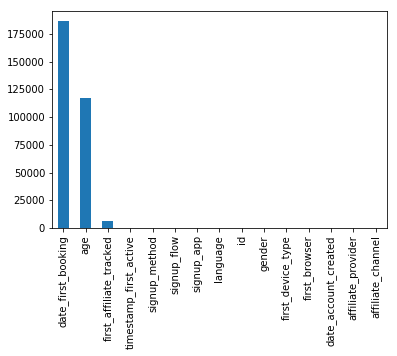

In [29]:
df_all.isnull().sum().sort_values(ascending = False).plot(kind="bar")

In [30]:
print('Missing data ratio')
print('date_frist_booking :',round(df_all.date_first_booking.isnull().sum() / len(df_all) * 100, 2))
print('age :',round(df_all.age.isnull().sum() / len(df_all) * 100, 2))
print('first_affiliate_tracked:',round(df_all.first_affiliate_tracked.isnull().sum() / len(df_all) * 100, 2))

Missing data ratio
date_frist_booking : 67.73
age : 42.41
first_affiliate_tracked: 2.21


#### (3) Explore Target

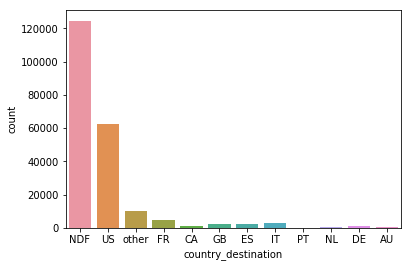

In [31]:
sns.countplot(df_train["country_destination"])

In [32]:
round(df_train["country_destination"].value_counts() / len(df_train) * 100, 2)

NDF      58.35
US       29.22
other     4.73
FR        2.35
IT        1.33
GB        1.09
ES        1.05
CA        0.67
DE        0.50
NL        0.36
AU        0.25
PT        0.10
Name: country_destination, dtype: float64

### 3. Feature Engineering

#### (1) Impute featrues

##### 1-1. Gender

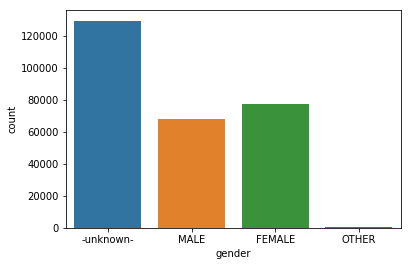

In [33]:
sns.countplot(df_all["gender"])

- female - male 

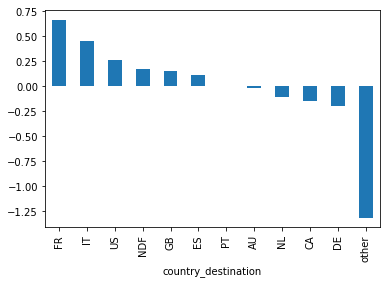

In [34]:
df_train["count"] = 1
df_gender_country = df_train.pivot_table(values = "count", index = ["country_destination"], columns = ["gender"], aggfunc=np.sum)
df_gender_country["FEMALE"] = df_gender_country["FEMALE"] / df_gender_country["FEMALE"].sum() * 100
df_gender_country["MALE"] = df_gender_country["MALE"] / df_gender_country["MALE"].sum() * 100
(df_gender_country["FEMALE"] - df_gender_country["MALE"]).sort_values(ascending = False).plot(kind="bar")

- 여자는 FR, IT 주로 여행을 간다. 
- 남자는 DE, other를 주로 여행을 간다

In [35]:
## code

##### 1-2. Age

In [75]:
labels = ["0~15", "16~25", "26~35", "36~60", "61~2010"]

In [76]:
df_train["age_cut"] = pd.qcut(df_train[df_train["age"] <= 120]['age'], 5, labels = labels)

In [77]:
df_age_pivot = df_train.pivot_table(values = "count", index = "age_cut", columns = "country_destination", aggfunc = np.sum, fill_value = 0)

In [78]:
df_age_pivot

country_destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
age_cut,,,,,,,,,,,,
0~15,65,174,186,448,695,351,437,12255,150,36,9808,1471
16~25,97,224,160,312,681,296,340,9995,102,35,10250,1550
26~35,78,219,159,373,738,336,429,10630,131,35,10561,1665
36~60,111,243,176,298,810,357,392,12083,111,23,9715,1521
61~2010,84,211,163,266,770,424,425,11561,103,28,8009,1324


In [79]:
for c in df_age_pivot.index:
    df_age_pivot.loc[c] = (df_age_pivot.loc[c] / (df_train["age_cut"] == c).sum() * 100)

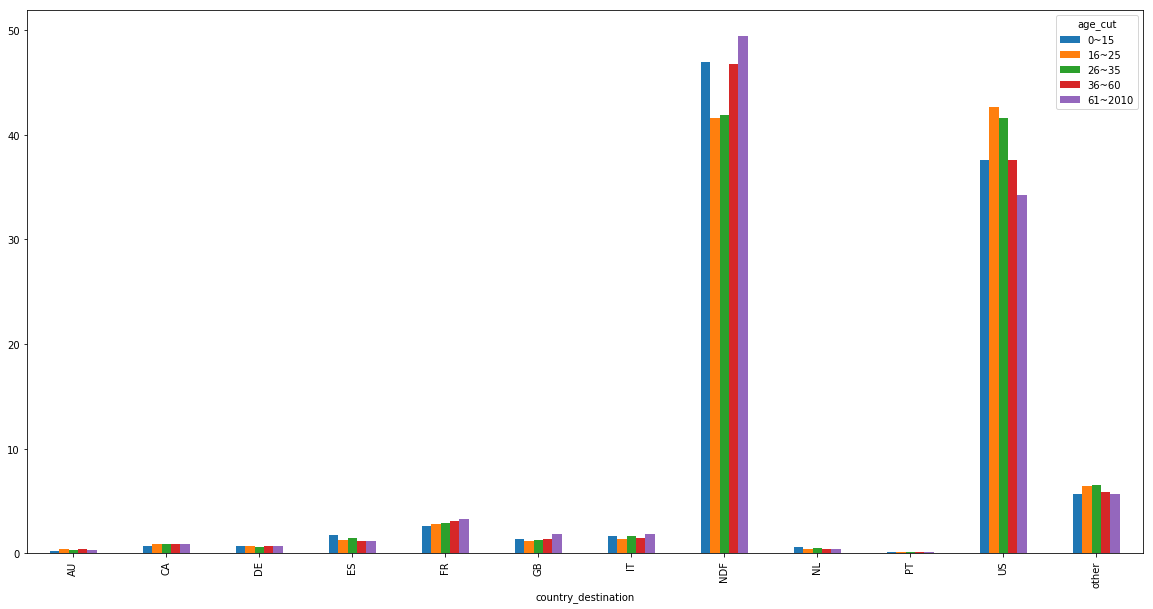

In [80]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 10))

(0, 4)

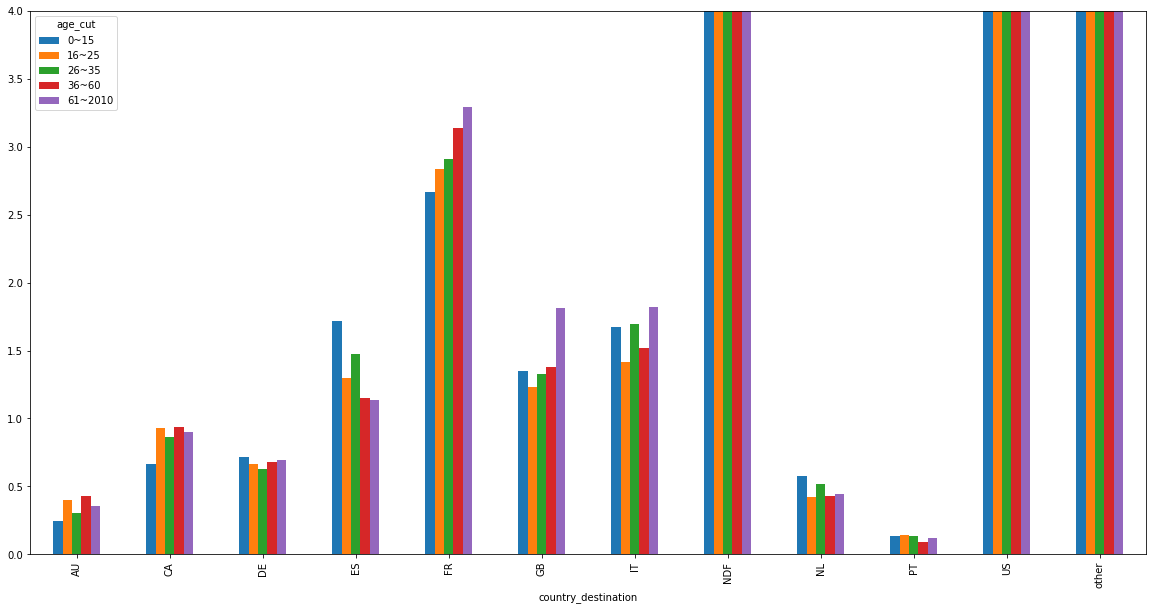

In [81]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 10))
plt.ylim([0,4])

- NDF : 27-36세는 NDF가 아닐 확률이 높다.
- US  : 27-36세는 US로 여행할 확률이 높다.
- FR  : 나이가 늘어 날수록 여행갈 비율이 높다.
- other : 27-36세는 other에 여행할 확률이 약간 높다.
- GB  : 46-세는 GB에 여행갈 확률이 높다
- ES  : 0-27세는 ES에 여행갈 확률이 높다.

##### 1-3. first_affiliate_tracked

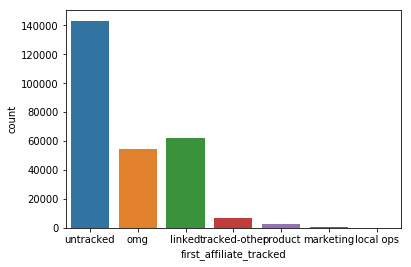

In [43]:
sns.countplot(df_all["first_affiliate_tracked"])

In [74]:
round(df_all["first_affiliate_tracked"].value_counts() / len(df_all) * 100, 2)

untracked        51.96
linked           22.52
omg              19.91
tracked-other     2.42
product           0.85
marketing         0.10
local ops         0.03
Name: first_affiliate_tracked, dtype: float64

- 전체 특징에서 51.96%가 untracked이기 때문에 최빈값 `untracked` 으로 Missing value 처리

In [45]:
## code
df_train["first_affiliate_tracked"].fillna("untracked")
df_test["first_affiliate_tracked"].fillna("untracked")

0            untracked
1            untracked
2               linked
3               linked
4            untracked
5                  omg
6            untracked
7            untracked
8            untracked
9                  omg
10           untracked
11           untracked
12              linked
13              linked
14           untracked
15              linked
16           untracked
17              linked
18                 omg
19              linked
20              linked
21           untracked
22              linked
23           untracked
24                 omg
25              linked
26                 omg
27                 omg
28             product
29              linked
             ...      
62066        untracked
62067        untracked
62068        untracked
62069        untracked
62070        untracked
62071        untracked
62072        untracked
62073        untracked
62074           linked
62075              omg
62076        untracked
62077        untracked
62078      

##### 1-4. date_first_booking

In [46]:
test_exist = len(df_test) - df_test["date_first_booking"].isnull().sum()
print("Number of date_first_booking in test : {}".format(test_exist))

Number of date_first_booking in test : 0


- test 데이터에는 date_first_booking 특징이 전혀 존재하지 않기 때문에 해당 특지은 사용하지 않는다.

In [47]:
## code
df_train.drop("date_first_booking", axis = 1, inplace = True)
df_test.drop("date_first_booking", axis = 1, inplace = True)

##### 1-5. gender

In [ ]:
df_age_pivot = df_train.pivot_table(values = "count", index = "age_cut", columns = "country_destination", aggfunc = np.sum, fill_value = 0)
df_age_pivot

In [ ]:
for c in df_age_pivot.index:
    df_age_pivot.loc[c] = (df_age_pivot.loc[c] / (df_train["age_cut"] == c).sum() * 100)

In [ ]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 10))

#### (2) Create featrues

##### 2-1. Faithless sign-in

- **가정) 가입을 꼼꼼하게 한 사람일수록 여행을 예약할 확률이 높다** 

  - `age`가 `nan`이거나 `이상값`이거나 `gender`가 `unknown`일 경우, 가입을 대충했다고 가정

In [48]:
s_all_input_train = (df_train['age'] < 120) & (df_train['gender'] != '-unknown-')
s_all_input_test = (df_test['age'] < 120) & (df_test['gender'] != '-unknown-')

In [49]:
df_train['faithless_sign'] = s_all_input_train.apply(lambda x : 0 if x == True else 1)
df_test['faithless_sign'] = s_all_input_test.apply(lambda x : 0 if x == True else 1)

In [ ]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 10))
plt.ylim([0,4])

##### 2-2. Session info

- **가정) 사이트를 자주 들어간 사람일수록 여행을 예약할 확률이 높다**
  - 각 `user_id`별 session count 갯수가 많을 수록, 사이트를 자주 들어 왔다고 가정
- **추가 사항 : secs_elapse_mean, secs_elapse_mode, secs_elapse_sum, device_type_mode**

##### action, action_type, action_detail count

In [53]:
## make action count
tmp = df_sessions.groupby(["user_id", "action_type"])["secs_elapsed"].count().unstack().fillna(0)
df_session_type = pd.DataFrame(tmp)
df_session_type.rename(columns = lambda x : "type_" + x, inplace = True)

In [57]:
## make action_type count
tmp = df_sessions.groupby(["user_id", "action"])["secs_elapsed"].count().unstack().fillna(0)
df_session_action = pd.DataFrame(tmp)
df_session_action.rename(columns = lambda x : "action_" + x, inplace = True)

In [58]:
## make action_detail count
tmp = df_sessions.groupby(["user_id", "action_detail"])["secs_elapsed"].count().unstack().fillna(0)
df_session_action_detail = pd.DataFrame(tmp)
df_session_action_detail.rename(columns = lambda x : "detail_" + x, inplace = True)

In [59]:
df_session_info = df_session_type.merge(df_session_action, how = "left", left_index = True, right_index = True)
df_session_info = df_session_info.merge(df_session_action_detail, how = "left", left_index = True, right_index = True)

In [60]:
## drop unknown value
df_session_info.drop(["type_-unknown-", "detail_-unknown-"], axis = 1, inplace = True)

In [65]:
## impute the missing value using median
from sklearn.preprocessing import Imputer

df_train_origin = df_train.copy()
df_test_origin = df_test.copy()

df_train = df_train_origin.merge(df_session_info, how = "left", left_on = "id", right_index = True)
df_test = df_test_origin.merge(df_session_info, how = "left", left_on = "id", right_index = True)

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

df_train[df_session_info.columns.tolist()] = imp.fit_transform(df_train[df_session_info.columns.tolist()])
df_test[df_session_info.columns.tolist()] = imp.fit_transform(df_test[df_session_info.columns.tolist()])

##### 2-3. Date info

- **가정1) 주말에 처음 활동한 사람일수록 여행을 예약할 확률이 높다** 
- **가정2) 공휴일에 처음 활동한 사람일수록 여행을 예약할 확률이 높다**
- **추가 사항 : first_active_year, first_active_month, first_active_day, first_active_weekend, create_account_year, create_account_month, create_account_day**

##### 2-4. Lag-time

- **가정) 활동 빈도가 적을 수록 여행을 예약할 확률이 낮다**
  - 처음으로 활동한 날짜 - 처음 계정을 생성한 날짜

In [62]:
df_train["date_account_created"] = pd.to_datetime(df_train["date_account_created"], format = "%Y-%m-%d")
df_train["timestamp_first_active"] = pd.to_datetime(df_train["timestamp_first_active"], format="%Y%m%d%H%M%S", errors='ignore')
df_test["date_account_created"] = pd.to_datetime(df_test["date_account_created"], format = "%Y-%m-%d")
df_test["timestamp_first_active"] = pd.to_datetime(df_test["timestamp_first_active"], format="%Y%m%d%H%M%S", errors='ignore')

In [63]:
s_train_lag = df_train["timestamp_first_active"] - df_train["date_account_created"]
s_test_lag = df_test["timestamp_first_active"] - df_test["date_account_created"]

In [64]:
df_train["lag_days"] = s_train_lag.apply(lambda x : -1 * x.days)
df_test["lag_days"] = s_test_lag.apply(lambda x : -1 * x.days)
df_train["lag_seconds"] = s_train_lag.apply(lambda x : x.seconds)
df_test["lag_seconds"] = s_test_lag.apply(lambda x : x.seconds)

#### (3) Featrues selection

##### 3-1. Use importance feature

### 4. Modeling

#### (1) Selection Model

#### (2) Parameter tuning

### 5. Analysis the result

In [4]:
train_all_remove = pd.read_csv("train_all_remove.csv")
test_all_remove = pd.read_csv("test_all_remove.csv")

In [18]:
train_all_remove.loc[:,['age', 'country_destination']]

,age,country_destination
0,35.0,NDF
1,38.0,NDF
2,56.0,US
3,42.0,other
4,41.0,US
5,35.0,US
6,46.0,US
7,47.0,US
8,50.0,US
9,46.0,US


In [22]:
train_all_remove.loc[:,['FEMALE', 'MALE', 'country_destination']]

,FEMALE,MALE,country_destination
0,0,1,NDF
1,0,1,NDF
2,1,0,US
3,1,0,other
4,1,0,US
5,1,0,US
6,1,0,US
7,1,0,US
8,1,0,US
9,1,0,US
